In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


In [2]:
in_folder = "audits/2018_04/data/"
out_folder = "audits/2018_04/images/"
#in_folder = "../data/"
#out_folder = "/tmp/"

# Analyse comparative des quantités de points d'arrêts

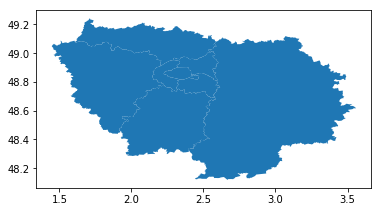

In [3]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [4]:
#on charge les données
osm_stoppoints = pd.read_csv(os.path.join(in_folder,"osm-transit-extractor_stop_points.csv"), dtype=str)
gtfs_stoppoints = pd.read_csv(os.path.join(in_folder,"gtfs_stops.txt"), dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]
zones_with_stoppoints_count = zones_with_stoppoints_count.sort_values("name").reset_index().drop("index", axis=1)
zones_with_stoppoints_count


,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5934,3685,62.099764
1,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3751,2781,74.140229
2,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3056,2413,78.959424
3,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4028,2601,64.572989
4,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8262,4609,55.785524
5,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4769,2981,62.507863
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3161,2716,85.922177
7,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8385,3976,47.418008


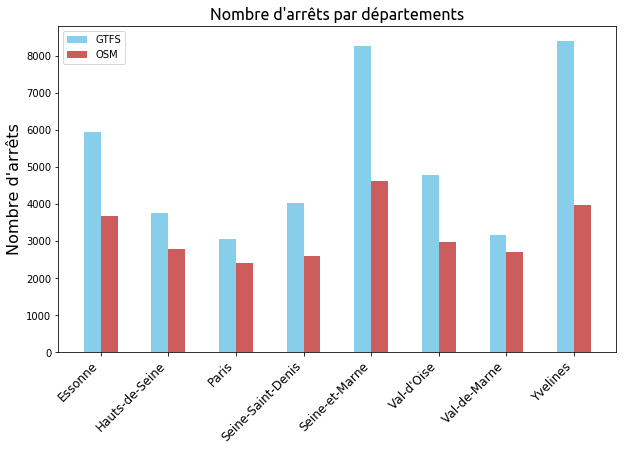

In [5]:
#histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind - width/2, zones_with_stoppoints_count["nb_stoppoints_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_stoppoints_count["nb_stoppoints_osm"], 
                width, color='IndianRed', label='OSM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Nombre d\'arrêts par départements', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre d\'arrêts', fontsize=16)

ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

plt.savefig(os.path.join(out_folder, '1_stoppoints_per_deptm_chart.png'), bbox_inches='tight')

In [6]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [7]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.82947893676231

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [8]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [9]:
len(osm_lines) * 100.0 / len(gtfs_lines)

49.667774086378735

In [10]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv(os.path.join(in_folder,"opendata_routepoints.csv"), dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [11]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv(os.path.join(in_folder, "osm_routepoints.csv"), dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count.sort_values("name", inplace=True)
zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14214,3677,25.868862
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7557,3740,49.490539
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",6671,4457,66.811572
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8421,2303,27.348296
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26317,3658,13.899761
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10153,3267,32.177681
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7540,3411,45.238727
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22149,1780,8.036480


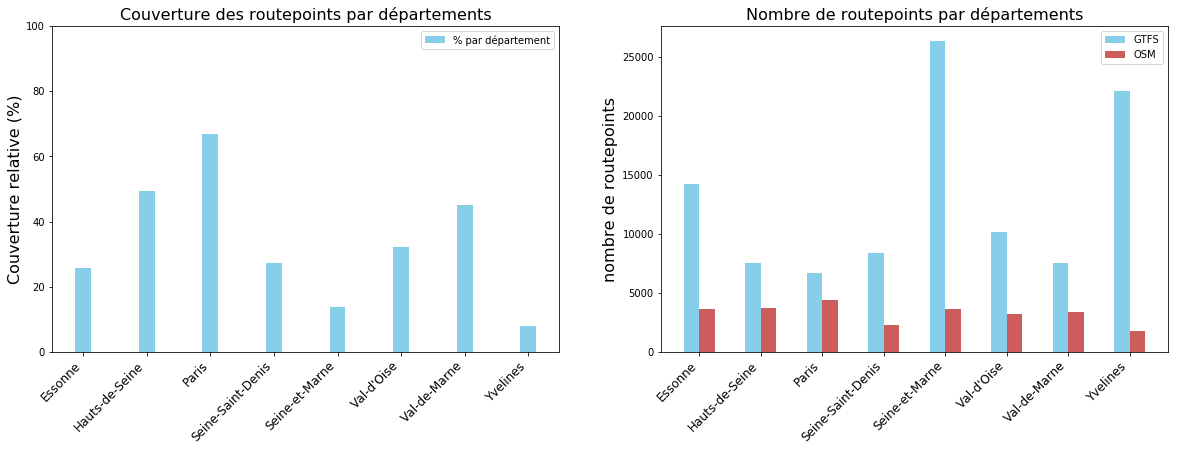

In [12]:
# histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig = plt.figure(figsize=(20, 6))
# 1er graph
ax = fig.add_subplot(121)
rects = ax.bar(ind, zones_with_routepoints_count["couverture_osm"], 
                width, color='SkyBlue', label='% par département')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 100)
ax.set_ylabel('Couverture relative (%)', fontsize=16)
ax.set_title('Couverture des routepoints par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

# 2eme graph
ax = fig.add_subplot(122)
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
rects1 = ax.bar(ind - width/2, zones_with_routepoints_count["nb_stops_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_routepoints_count["nb_stops_osm"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('nombre de routepoints', fontsize=16)
ax.set_title('Nombre de routepoints par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()


plt.savefig(os.path.join(out_folder,'3_routepoints_per_deptm.png'), bbox_inches='tight')

In [13]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [14]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

25.394189268782526

In [15]:
#nombre moyen de terminus par ligne, pour OSM
osm_lines_and_routes = osm_routepoints[["osm_line_id","osm_route_id" ]].copy()
osm_lines_and_routes.drop_duplicates(inplace=True)
counts_routes_osm = osm_lines_and_routes.groupby('osm_line_id').size()
print("nombre moyen de terminus par ligne dans OSM : {:f}".format(counts_routes_osm.mean()))

#nombre moyen de terminus par ligne, pour le GTFS
gtfs_lines_and_routes = gtfs_routepoints[["gtfs_route_id","gtfs_dest_name" ]].copy()
gtfs_lines_and_routes.drop_duplicates(inplace=True)
counts_routes_gtfs = gtfs_lines_and_routes.groupby('gtfs_route_id').size()
print("nombre moyen de terminus par ligne dans le GTFS : {:f}".format(counts_routes_gtfs.mean()))

nombre moyen de terminus par ligne dans OSM : 2.073140
nombre moyen de terminus par ligne dans le GTFS : 3.122370


# Analyse quantitative par réseau

In [16]:
osm_routepoints_cleaned = osm_routepoints.copy()

#attention à ces deux mappings à ne pas faire
#osm_routepoints_cleaned.replace(to_replace="Navettes Aéroports De Paris", value="ADP", inplace=True)
#osm_routepoints_cleaned.replace(to_replace="R'bus", value="rbus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Les Courriers de l'Île-de-France", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Keolis CIF", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Bus Val d'Oise", value="Busval d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Transdev CEAT", value="CEAT", inplace=True)
osm_routepoints_cleaned.replace(to_replace="La Navette Paris-Saclay", value="Paris-Saclay", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Réseau interurbain de Rambouillet", value="Rambouillet Interurbain", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Canton de Perthes en Gâtinais", value="Réseau du Canton de Perthes", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Seine-et-Marne Express", value="Seine et Marne Express", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sénart Bus", value="Sénart-Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Tice", value="TICE", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sit'bus", value="Sit'Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Situs", value="SITUS", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYbus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYBUS", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SqyBus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="TransVO", value="Trans Val d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Still", value="STILL", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Î", value="I", inplace=True)
osm_routepoints_cleaned.replace(to_replace="R'bus", value="R'Bus", inplace=True)

osm_networks = pd.DataFrame(osm_routepoints_cleaned.groupby('osm_network').size()).reset_index()
osm_networks.rename(columns={0: 'osm_routepoints_count'}, inplace=True)
osm_networks["osm_network_lower"] = osm_networks["osm_network"].str.lower()

gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
gtfs_agency_line_count = gtfs_routepoints.groupby('gtfs_agency_name').gtfs_route_short_name.nunique().reset_index()
gtfs_networks = gtfs_networks.merge(gtfs_agency_line_count, how='left', on='gtfs_agency_name')
gtfs_networks.rename(columns={0: 'gtfs_routepoints_count', "gtfs_route_short_name":"gtfs_lines_count"}, inplace=True)
gtfs_networks['gtfs_agency_name_lower'] = gtfs_networks['gtfs_agency_name'].str.lower()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network_lower'], left_on=['gtfs_agency_name_lower'])
networks.drop('osm_network', axis=1, inplace=True)
networks.drop('osm_network_lower', axis=1, inplace=True)
networks.drop('gtfs_agency_name_lower', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_routepoints_count'] * 100.0 / networks['gtfs_routepoints_count']

### Top 10 des réseaux les plus mappés

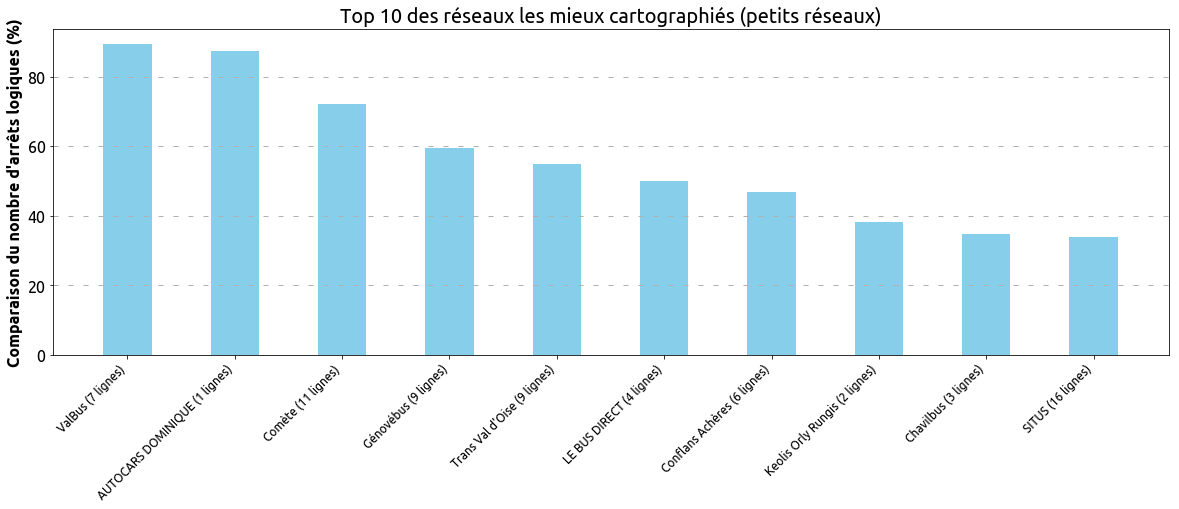

In [17]:
# TOP 10 des petits réseaux
networks_top_10 = networks[networks["gtfs_lines_count"] < 20].sort_values("osm_couverture", ascending=False).head(10)
networks_top_10["label"] = networks_top_10["gtfs_lines_count"].apply(str)
networks_top_10["label"] = networks_top_10["gtfs_agency_name"] + ' (' + \
    networks_top_10["label"].astype(str) + ' lignes)'

#networks_top_10

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_top_10["osm_couverture"], 
                width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les mieux cartographiés (petits réseaux)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_top_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)

plt.savefig(os.path.join(out_folder, '7_routepoints_top10_petits_reseaux.png'), bbox_inches='tight')

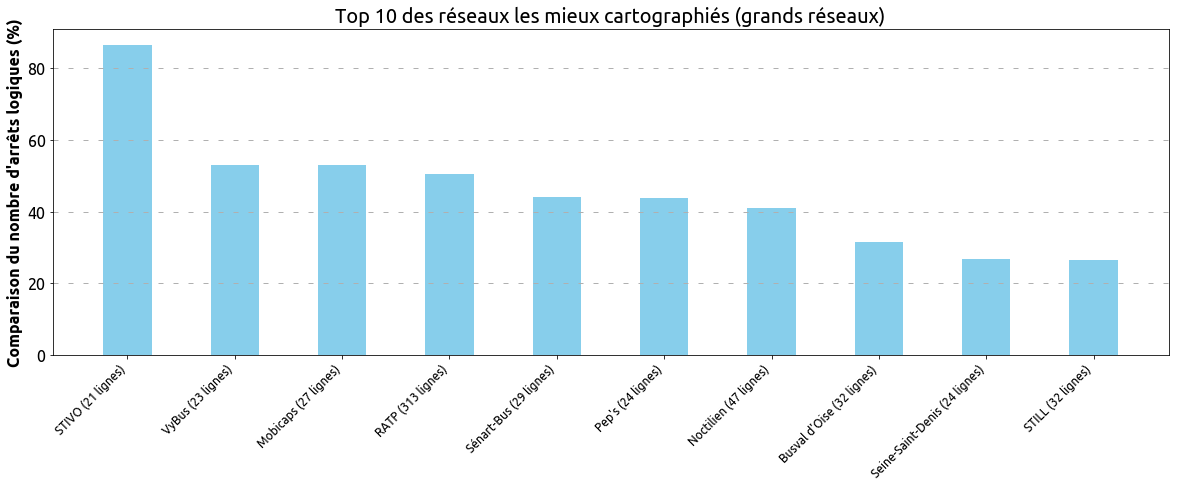

In [18]:
# TOP 10 des grands réseaux 
networks_top_10 = networks[(networks["gtfs_lines_count"] >= 20)].sort_values("osm_couverture", ascending=False).head(10)
networks_top_10["label"] = networks_top_10["gtfs_lines_count"].apply(str)
networks_top_10["label"] = networks_top_10["gtfs_agency_name"] + ' (' + \
    networks_top_10["label"].astype(str) + ' lignes)'

#networks_top_10

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_top_10["osm_couverture"], 
                width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les mieux cartographiés (grands réseaux)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_top_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)

plt.savefig(os.path.join(out_folder, '7_routepoints_top10_plus_20_lignes.png'), bbox_inches='tight')

In [19]:
#networks.sort_values("osm_couverture", ascending=False).reset_index()

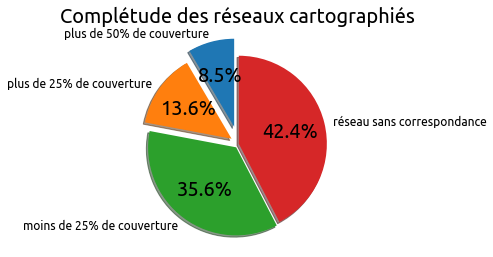

In [20]:
# nombre de réseaux mappés à plus de 50%
network_full_count = gtfs_networks.shape[0]
network_mapped_count = networks.shape[0]
networks_plus_50 = networks[networks["osm_couverture"] >= 50]
count_plus_50 = networks_plus_50.shape[0]
networks_plus_25 = networks[(networks["osm_couverture"] >= 25) & (networks["osm_couverture"] < 50)]
count_plus_25 = networks_plus_25.shape[0]
labels = 'plus de 50% de couverture', 'plus de 25% de couverture', 'moins de 25% de couverture', 'réseau sans correspondance'
portion_plus_50 = count_plus_50/network_full_count * 100
portion_plus_25 = count_plus_25/network_full_count * 100
portion_unmapped = (1 - network_mapped_count / network_full_count) * 100
portion_reste = 100 - portion_plus_50 - portion_plus_25 - portion_unmapped
sizes = [portion_plus_50, portion_plus_25, portion_reste, portion_unmapped]
explode = (0.2, 0.1, 0.05, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.set_title('Complétude des réseaux cartographiés')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig(os.path.join(out_folder, '8_network_cover_in_routepoints.png'), bbox_inches='tight')